* pip install -U scikit-allel
* pip install vcfnp
* pip install petl
* pip install seaborn

Heavily munged from [The Scikit Allel walkthrough](http://alimanfoo.github.io/2015/09/28/fast-pca.html), and the [vcfnp notebook](http://nbviewer.ipython.org/github/alimanfoo/vcfnp/blob/master/example.ipynb)

* [EggNog GO db](http://eggnogdb.embl.de/#/app/seqscan)

In [136]:
from __future__ import print_function, division
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas
import vcfnp
import allel
import subprocess
import os
vcfnp.__version__

'2.2.0'

### Set up data dirs to pull from

In [139]:
DATA_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Pyrad-output/Step6/"
POPS_FILES_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Fastsimcoal2/PopsFiles/"
OUTLIERS_DIR="/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/"
SAM_DIR="/Users/iovercast/Desktop/MarTum/ReadMapping/smalt-work/"
READ_MAPPING_DIR = "/Users/iovercast/Desktop/MarTum/ReadMapping/"
ZF_REF = READ_MAPPING_DIR+"zf/zf.rm.fa"
ZF_REF_CDNA = READ_MAPPING_DIR+"zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa"

In [3]:
specieslist = os.listdir(DATA_DIR)
print(specieslist)

['Arremon', 'Campylorhynchus', 'Melanopareia', 'Mimus', 'Saltator', 'Thamnophilus']


In [142]:
#for species in ["Arremon"]:
for species in specieslist:
    print("Doing - "+species)
    # Load the vcf files
    # Actually read in the variants, this gives us access to CHROM
    v = vcfnp.variants(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf").view(np.recarray)
    
    ## Read outliers
    ## Outliers are generated with an R script that makes use of PCAdapt to detect
    ## outlier snps. Called MarTum-pcadapt-outlier-anaylsis.R, you could probably call
    ## this on the fly, but i ran it once in rstudio and am just using the results
    ## PCAdapt pub: http://arxiv.org/pdf/1402.5321.pdf
    outliers_file = open(OUTLIERS_DIR+species+".outliers")
    ## outliers here is a list of snp indices in the vcf file that are outliers
    outliers = outliers_file.readlines()
    
    # Read Loci file
    loci_file = open(DATA_DIR+species+"/outfiles/c85d6m4p3.loci")
    loci = loci_file.read().split("|")
    
    # Read sam file
    sam_file = open(SAM_DIR+species+".sam")
    sam = sam_file.read()
    
    ## For each outlier snp identify the stack it's from in the .loci file
    ## We subtract 1 here because the variant array is 0-based and the
    ## snp outliers are reported 1-based
    outlier_loci_nums = []
    for o in outliers:
        #print(int(o), v[int(o)-1].CHROM)
        outlier_loci_nums.extend([v[int(o)-1].CHROM])

    ## Make a sorted set of loci. Removes duplicates in the event that
    ## multiple snps are outliers
    sorted_loci_nums = sorted(set(outlier_loci_nums), key=int)
    
    print("# outlier loci = ", len(sorted_loci_nums))
    
    ## For each outlier locus grab the first sequence
    ## Again, sorted_loci are 1-based and loci from the file are 0-based
    outlier_loci = {}
    for l in sorted_loci_nums:
        ## Replace all indels with N because that's what's in the sam files
        outlier_loci[l] = loci[int(l)-1].split()[1].split("nnnn")[0].replace('-','N')
        
    ## Find them in the sam file
    ## Don't really care anymore, we just remap all the outlier loci by hand
    ## saves the trouble of digging for them
    found_loci = []
    for l in outlier_loci.values():
        if l in sam:
            found_loci.extend([l])

    out_fa = OUTLIERS_DIR+species+".outliers.fa"
    ## Write out a dummy fasta file with dummy names and real seqs, just for mapping.
    with open(out_fa, 'w') as outfile:
        for i,l in enumerate(outlier_loci.values()):
            outfile.write(">"+str(i)+"\n"+l+"\n")

    output = OUTLIERS_DIR+species+".cdna.sam"
    SMALT_CMD = "smalt map -f samsoft -n 8 -y 0.8 -o " + output
    cmd = SMALT_CMD, ZF_REF_CDNA, out_fa
    print(cmd)
    print("SMALT - Mapping reads for " + species)
    output = subprocess.check_output( " ".join(cmd), shell=True)
    print(output)
    

[vcfnp] 2016-04-23 21:08:56.372643 :: caching is disabled
[vcfnp] 2016-04-23 21:08:56.373494 :: building array


Doing - Arremon
# outlier loci =  1190
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Arremon.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Arremon.outliers.fa')
SMALT - Mapping reads for Arremon


[vcfnp] 2016-04-23 21:09:14.436668 :: caching is disabled
[vcfnp] 2016-04-23 21:09:14.437652 :: building array



Doing - Campylorhynchus
# outlier loci =  359
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Campylorhynchus.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Campylorhynchus.outliers.fa')
SMALT - Mapping reads for Campylorhynchus


[vcfnp] 2016-04-23 21:09:24.321184 :: caching is disabled
[vcfnp] 2016-04-23 21:09:24.322309 :: building array



Doing - Melanopareia
# outlier loci =  2075
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Melanopareia.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Melanopareia.outliers.fa')
SMALT - Mapping reads for Melanopareia


[vcfnp] 2016-04-23 21:09:53.590837 :: caching is disabled
[vcfnp] 2016-04-23 21:09:53.591797 :: building array



Doing - Mimus
# outlier loci =  813
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Mimus.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Mimus.outliers.fa')
SMALT - Mapping reads for Mimus


[vcfnp] 2016-04-23 21:10:08.688802 :: caching is disabled
[vcfnp] 2016-04-23 21:10:08.689897 :: building array



Doing - Saltator
# outlier loci =  1770
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Saltator.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Saltator.outliers.fa')
SMALT - Mapping reads for Saltator


[vcfnp] 2016-04-23 21:10:48.200527 :: caching is disabled
[vcfnp] 2016-04-23 21:10:48.201525 :: building array



Doing - Thamnophilus
# outlier loci =  1247
('smalt map -f samsoft -n 8 -y 0.8 -o /Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Thamnophilus.cdna.sam', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/Taeniopygia_guttata.taeGut3.2.4.cdna.all.fa', '/Users/iovercast/Desktop/MarTum/ReadMapping/zf-cdna/outliers/Thamnophilus.outliers.fa')
SMALT - Mapping reads for Thamnophilus



In [149]:
## Extract the reads that hit to coding regions
#for species in ["Arremon"]:
for species in specieslist:
    species_hits_file = OUTLIERS_DIR+species+".hits"
    count = 0
    with open(species_hits_file, 'w') as outhits:
        with open(OUTLIERS_DIR+species+".cdna.sam") as insam:
            for line in insam:
                if "ENST" in line and not "@SQ" in line:
                    #print(line.split()[2])
                    count += 1
                    outhits.write(line.split()[2]+"\n")
    print(species, "=", str(count))

Arremon = 34
Campylorhynchus = 15
Melanopareia = 53
Mimus = 30
Saltator = 69
Thamnophilus = 59


In [231]:
## Turn hits on transcripts to hits on genes
#for species in ["Arremon"]:
for species in specieslist:
    print("Doing - "+species)
    species_hits_file = OUTLIERS_DIR+species+".hits"
    species_gene_hits_file = OUTLIERS_DIR+species+".cds.hits"
    inhits_file = open(species_hits_file)
    inhits = inhits_file.readlines()
    print(inhits)
    inhits = [x.strip() for x in inhits]
#    for i in inhits:
#        print(i)
    zf = open(ZF_REF_CDNA)
    zfcdna = zf.readlines()
    with open(species_gene_hits_file, 'w') as outcdshits:
            for line in inhits:
                #print(line)
                for i in zfcdna:
                    if line in i:
                        found = i.split(":")[7].split(".")[0]
                        outcdshits.write(found+"\t"+i+"\n")
                        print("found", found)

['ENSTGUT00000002499.1\n', 'ENSTGUT00000005620.1\n', 'ENSTGUT00000000603.1\n', 'ENSTGUT00000005406.1\n', 'ENSTGUT00000009188.1\n', 'ENSTGUT00000007990.1\n', 'ENSTGUT00000018194.1\n', 'ENSTGUT00000002488.1\n', 'ENSTGUT00000006140.1\n', 'ENSTGUT00000006506.1\n', 'ENSTGUT00000011420.1\n', 'ENSTGUT00000008997.1\n', 'ENSTGUT00000017958.1\n', 'ENSTGUT00000016862.1\n', 'ENSTGUT00000006063.1\n', 'ENSTGUT00000006123.1\n', 'ENSTGUT00000000170.1\n', 'ENSTGUT00000008763.1\n', 'ENSTGUT00000002835.1\n', 'ENSTGUT00000007165.1\n', 'ENSTGUT00000000459.1\n', 'ENSTGUT00000015497.1\n', 'ENSTGUT00000003238.1\n', 'ENSTGUT00000017550.1\n', 'ENSTGUT00000007168.1\n', 'ENSTGUT00000001536.1\n', 'ENSTGUT00000010005.1\n', 'ENSTGUT00000011950.1\n', 'ENSTGUT00000010830.1\n', 'ENSTGUT00000008867.1\n', 'ENSTGUT00000014418.1\n', 'ENSTGUT00000000984.1\n', 'ENSTGUT00000000152.1\n', 'ENSTGUT00000014451.1\n']
ENSTGUT00000002499.1
found ENSTGUG00000002344
ENSTGUT00000005620.1
found ENSTGUG00000005415
ENSTGUT00000000603.1
fo

In [233]:
## Any hits to the same gene?
hit_dict = {}
for species in specieslist:
    species_gene_hits_file = OUTLIERS_DIR+species+".cds.hits"
    with open(species_gene_hits_file) as inhits:
        hit_dict[species] = [x.strip().split("\t")[0] for x in inhits.readlines()]
#print(set.intersection(*[set(x) for x in hit_dict.values()]))

annotation_dict = {}
for i, species in enumerate(specieslist):
    for j in range(len(specieslist)):
        if i == j:
            continue
        annotation_dict[specieslist[i]+"-"+specieslist[j]] = set.intersection(set(hit_dict[species]), set(hit_dict[specieslist[j]]))
        #print(specieslist[i], specieslist[j])
        #print(set.intersection(set(hit_dict[species]), set(hit_dict[specieslist[j]])))

all_shared = set.union(*[x for x in annotation_dict.values()])
for i in list(all_shared):
    print(i)


ENSTGUG00000013842
ENSTGUG00000006903
ENSTGUG00000009780
ENSTGUG00000005690
ENSTGUG00000005989
ENSTGUG00000003883
ENSTGUG00000002389
ENSTGUG00000002919
ENSTGUG00000007059
ENSTGUG00000018478
ENSTGUG00000007345
ENSTGUG00000010564
ENSTGUG00000007224
ENSTGUG00000011160
ENSTGUG00000008339
ENSTGUG00000007255
ENSTGUG00000015456
ENSTGUG00000011459
ENSTGUG00000011567
ENSTGUG00000002967
ENSTGUG00000008196
ENSTGUG00000003720
ENSTGUG00000012691
ENSTGUG00000000981
ENSTGUG00000001137
ENSTGUG00000011662
ENSTGUG00000001477
ENSTGUG00000002344
ENSTGUG00000005969
ENSTGUG00000007681
ENSTGUG00000003074
ENSTGUG00000014877
ENSTGUG00000000259


In [193]:
## Any hits to the same transcript?
hit_dict = {}
for species in specieslist:
    species_hits_file = OUTLIERS_DIR+species+".hits"
    with open(species_hits_file) as inhits:
        hit_dict[species] = [x.strip().strip(".1") for x in inhits.readlines()]
#print(set.intersection(*[set(x) for x in hit_dict.values()]))

annotation_dict = {}
for i, species in enumerate(specieslist):
    for j in range(len(specieslist)):
        if i == j:
            continue
        annotation_dict[specieslist[i]+"-"+specieslist[j]] = set.intersection(set(hit_dict[species]), set(hit_dict[specieslist[j]]))
        #print(specieslist[i], specieslist[j])
        #print(set.intersection(set(hit_dict[species]), set(hit_dict[specieslist[j]])))

all_shared = set.union(*[x for x in annotation_dict.values()])
for i in list(all_shared):
    print(i)

ENSTGUT0000000868
ENSTGUT00000018928
ENSTGUT00000004409
ENSTGUT00000007990
ENSTGUT00000003238
ENSTGUT00000001186
ENSTGUT00000000270
ENSTGUT00000011627
ENSTGUT00000010205
ENSTGUT00000002499
ENSTGUT00000016114
ENSTGUT00000003083
ENSTGUT00000006229
ENSTGUT00000011005
ENSTGUT00000007168
ENSTGUT00000013210
ENSTGUT00000005928
ENSTGUT00000007663
ENSTGUT0000001216
ENSTGUT00000011950
ENSTGUT0000001205
ENSTGUT00000007359
ENSTGUT00000003047
ENSTGUT00000002488
ENSTGUT00000006212
ENSTGUT00000015497
ENSTGUT00000001536
ENSTGUT00000008590
ENSTGUT00000007709
ENSTGUT00000007563
ENSTGUT00000003869


In [192]:
print(list(all_shared))

[set(['ENSTGUT0000000868', 'ENSTGUT00000018928', 'ENSTGUT00000004409', 'ENSTGUT00000007990', 'ENSTGUT00000003238', 'ENSTGUT00000001186', 'ENSTGUT00000000270', 'ENSTGUT00000011627', 'ENSTGUT00000010205', 'ENSTGUT00000002499', 'ENSTGUT00000016114', 'ENSTGUT00000003083', 'ENSTGUT00000006229', 'ENSTGUT00000011005', 'ENSTGUT00000007168', 'ENSTGUT00000013210', 'ENSTGUT00000005928', 'ENSTGUT00000007663', 'ENSTGUT0000001216', 'ENSTGUT00000011950', 'ENSTGUT0000001205', 'ENSTGUT00000007359', 'ENSTGUT00000003047', 'ENSTGUT00000002488', 'ENSTGUT00000006212', 'ENSTGUT00000015497', 'ENSTGUT00000001536', 'ENSTGUT00000008590', 'ENSTGUT00000007709', 'ENSTGUT00000007563', 'ENSTGUT00000003869'])]


In [ ]:
# Stable recombination hotspots in birds
# http://science.sciencemag.org.ezproxy.gc.cuny.edu/content/350/6263/928
# http://science.sciencemag.org.ezproxy.gc.cuny.edu/content/sci/suppl/2015/11/18/350.6263.928.DC1/aad0843-Singhal-SM.pdf

# ZF GO site: http://www.ark-genomics.org/tools/GOfinch
# Other useful GO site: http://cegg.unige.ch/OrthoDB7/results?searchtext=EOG7B8S3S

# Annotations
# Protein Sidekick-2 http://www.uniprot.org/uniprot/Q58EX2
# Myosin, Heavy Chain 7B, Cardiac Muscle, Beta http://www.genecards.org/cgi-bin/carddisp.pl?gene=MYH7B

# Also map divergent regions to the full reference so you can look at divergence wrt recombination rate across chroms.

### Helper functions for plotting

In [5]:
pop_colours = {
    'Mar': '#FF0000',
    'Tum': '#0000FF'
}

# This isn't used right now.
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.stats.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
    
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

df_samples = []
populations = []
def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = df_samples[1].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
def get_pops( species ):
    # load the populations files
    df_samples = pandas.read_csv(POPS_FILES_DIR+species+"_pops.txt", delimiter=" ", header=None)

    df_samples.head()
    populations = df_samples[1].unique()
    return( df_samples, populations )

### For each species go through and do the plot

[vcfnp] 2016-03-11 17:10:33.072038 :: caching is disabled
[vcfnp] 2016-03-11 17:10:33.072545 :: building array


Doing - Arremon
calls (phased, variant, missing): 672923 (287076, 66343, 385847)
Doing - Campylorhynchus

[vcfnp] 2016-03-11 17:10:42.176160 :: caching is disabled
[vcfnp] 2016-03-11 17:10:42.176596 :: building array



calls (phased, variant, missing): 366942 (164022, 29702, 202920)
Doing - Melanopareia

[vcfnp] 2016-03-11 17:10:46.951615 :: caching is disabled
[vcfnp] 2016-03-11 17:10:46.952226 :: building array



calls (phased, variant, missing): 640492 (294697, 77093, 345795)
Doing - Mimus

[vcfnp] 2016-03-11 17:10:55.230100 :: caching is disabled
[vcfnp] 2016-03-11 17:10:55.230558 :: building array



calls (phased, variant, missing): 434874 (171259, 37455, 263615)
Doing - Saltator

[vcfnp] 2016-03-11 17:11:01.044557 :: caching is disabled
[vcfnp] 2016-03-11 17:11:01.045003 :: building array



calls (phased, variant, missing): 1063062 (421361, 103729, 641701)
Doing - Thamnophilus

[vcfnp] 2016-03-11 17:11:14.444455 :: caching is disabled
[vcfnp] 2016-03-11 17:11:14.444892 :: building array



calls (phased, variant, missing): 479886 (171497, 40540, 308389)


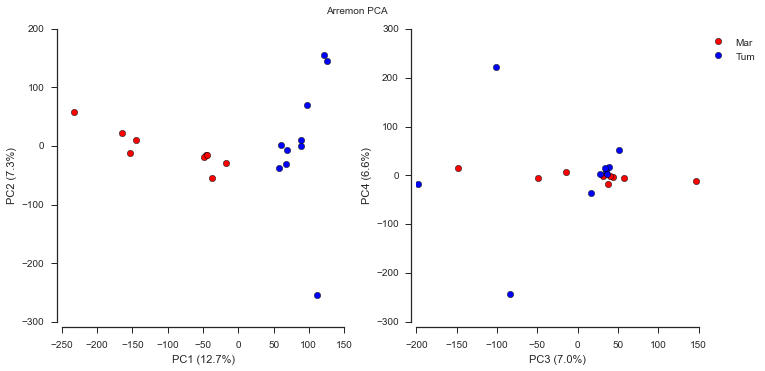

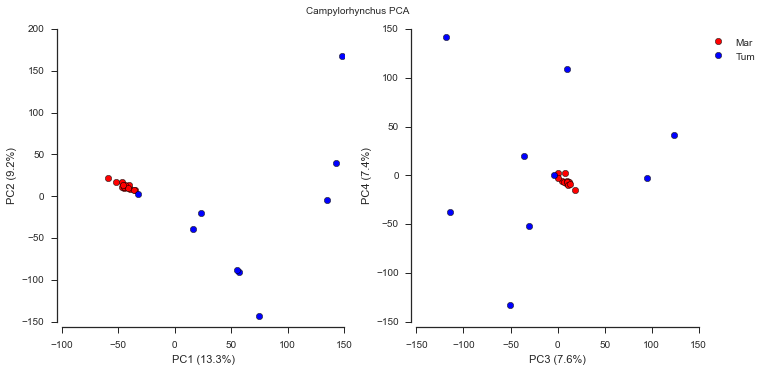

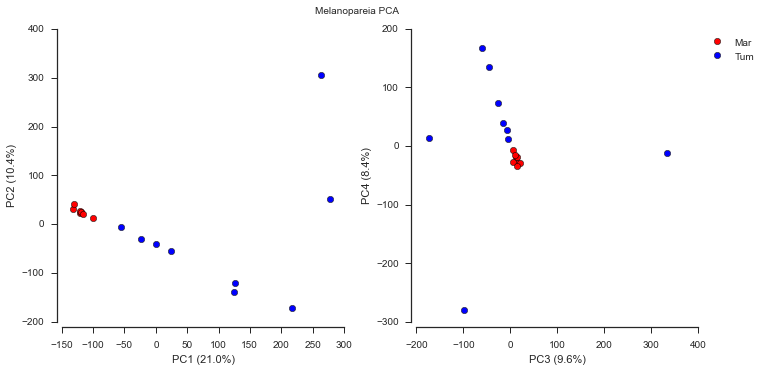

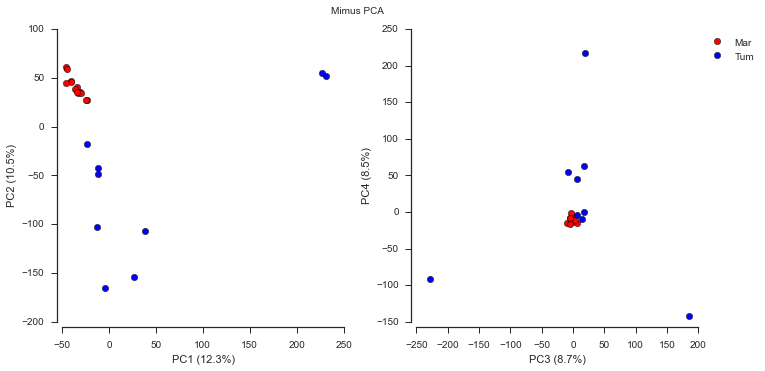

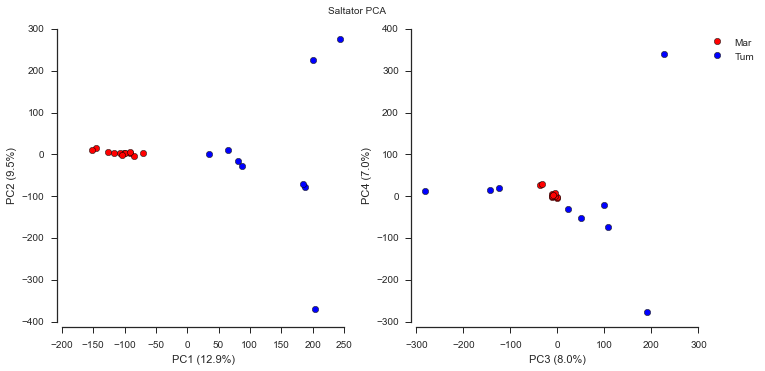

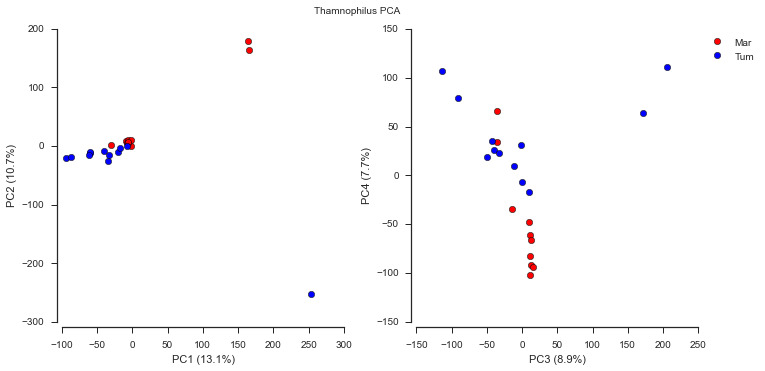

In [7]:
#for species in ["Arremon"]:
for species in specieslist:
    print("Doing - "+species)
    # Load the vcf files
    # This is another way to load the vcf, but we don't use it.
    #v = vcfnp.variants(DATA_DIR+"Arremon/outfiles/c85d6m4p3.vcf").view(np.recarray)
    c = vcfnp.calldata_2d(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf").view(np.recarray)
    
    # This is technically not that interesting or useful so get rid of it if its annoying
    # print some simple genotype metrics
    count_phased = np.count_nonzero(c.is_phased)
    count_variant = np.count_nonzero(np.any(c.genotype > 0, axis=2))
    count_missing = np.count_nonzero(~c.is_called)
    print('calls (phased, variant, missing): %s (%s, %s, %s)'
        % (c.flatten().size, count_phased, count_variant, count_missing))

    # Make the genotype array and count # of alleles at each position
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()

    # Munging and transforming the data into a format pca will like
    np.count_nonzero(ac.max_allele() > 1)
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()

    # Must reinitialize the df_samples np array
    df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )

    # Do the pca and then plot it
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig_pca(coords1, model1, species+" PCA")


## Calculate some population genetic summary stats for each species pair

In [8]:
#for species in ["Mimus"]:
for species in specieslist:
    print("Doing - "+species)
    # Load the vcf files
    # This is another way to load the vcf, but we don't use it.
    #v = vcfnp.variants(DATA_DIR+"Arremon/outfiles/c85d6m4p3.vcf").view(np.recarray)
    c = vcfnp.calldata_2d(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf", verbose=False).view(np.recarray)

    # Make the genotype array and count # of alleles at each position
    g = allel.GenotypeArray(c.genotype)
    
    # Get the population assignments
    # Must reinitialize the df_samples np array
    df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )

    pop1 = "Mar"
    pop2 = "Tum"
    pos_all = allel.SortedIndex(range(0, len(g)))
    subpops = {
        pop1: df_samples[df_samples[1] == pop1].index,
        pop2: df_samples[df_samples[1] == pop2].index,
    }

    # Filter out multi-allelic and sites that don't segragate
    # in the populations
    acs = g.count_alleles_subpops(subpops)
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    print('retaining', np.count_nonzero(flt), 'biallelic SNPs')
    pos = pos_all.compress(flt)
    genotype = g.compress(flt, axis=0)
    biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
    biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
    
    # subset genotype array per population
    g_mar = g.subset(range(0, len(g)), np.where( df_samples[1] == pop1 )[0])
    g_tum = g.subset(range(0, len(g)), np.where( df_samples[1] == pop2 )[0])
    
    # Get per population allele counts
    ac_mar = g.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
    ac_tum = g.count_alleles(subpop = np.where( df_samples[1] == pop2 )[0])

    # Get pi per population
    pi_mar = allel.stats.sequence_diversity( range(1, len(g)), ac_mar )
    pi_tum = allel.stats.sequence_diversity( range(1, len(g)), ac_tum )
    print( "Pi Mar = ", pi_mar )
    print( "Pi Tum = ", pi_tum )
    
    # Not stupid Pi
    sum = 0
    for i in range(len(g)):
        sum += allel.stats.sequence_diversity( i, ac_mar )/225
    print( "pi fix = ", sum/len(g))

    # Get average observed and expected heterozygosity per population
    ho_mar = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_mar)))/len(g_mar)
    af_mar = g_mar.count_alleles().to_frequencies()
    he_mar = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_mar, ploidy=2)))/len(g_mar)
    ho_tum = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_tum)))/len(g_tum)
    af_tum = g_tum.count_alleles().to_frequencies()
    he_tum = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_tum, ploidy=2)))/len(g_tum)
    print( "Ho / He Mar = ", ho_mar, he_mar )
    print( "Ho / He Tum = ", ho_tum, he_tum )
    
    # Get Watterson's Theta per population
    ThetaHat_mar = allel.stats.diversity.watterson_theta( range(1, len(g)), ac_mar)
    ThetaHat_tum = allel.stats.diversity.watterson_theta( range(1, len(g)), ac_tum)
    print( "ThetaHat Mar = ", ThetaHat_mar )
    print( "ThetaHat Tum = ", ThetaHat_tum )
    
    # Get Tajima's D per population
    TajD_mar = allel.stats.diversity.tajima_d( range(1, len(g)), ac_mar )
    TajD_tum = allel.stats.diversity.tajima_d( range(1, len(g)), ac_tum )
    print( "Tajima's D Mar = ", TajD_mar )
    print( "Tajima's D Tum = ", TajD_tum )

    # Print pairwise differences Dxy
    Dxy = allel.stats.diversity.sequence_divergence( range(1, len(g)), ac_mar, ac_tum)
    print( "Dxy = ",Dxy )

    # W & C Fst
    a, b, c = allel.stats.weir_cockerham_fst(g, [np.where( df_samples[1] == pop1)[0], np.where( df_samples[1] == pop2)[0]])
    fst = np.sum(np.nan_to_num(a)) / (np.sum(np.nan_to_num(a)) + np.sum(np.nan_to_num(b)) + np.sum(np.nan_to_num(c)))
    print( "W&C Fst = ", fst )

    # Hudson's Fst
    num, den = allel.stats.hudson_fst(ac_mar, ac_tum)
    fst = np.sum(np.nan_to_num(num)) / np.sum(np.nan_to_num(den))
    print( "Hudson's Fst = ", fst )

    print( "\n" )
    # Compute and plot pairwise distances for all individuals.
    # Lots of different options for distance metric, see here for more docs:
    # http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.distance.pdist.html
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist())
    
    # Compute and plot pairwise Dxy
    # This works, it just maybe is tmi at this point
    #dist = allel.stats.distance.pairwise_dxy( range(0, len(g)), g.to_allele_counts() )
    #allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist() )

Doing - Arremon
retaining 34470 biallelic SNPs
Pi Mar =  0.15058086094
Pi Tum =  0.234235716219


TypeError: array with 1 dimension required

## Pairwise distances between individuals

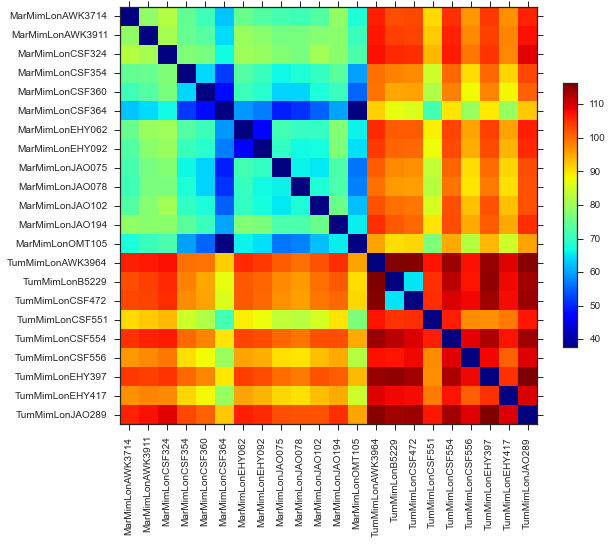

In [239]:
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist())

## Stats based on biallelic markers only

In [469]:
# Get Watterson's Theta per population
ThetaHat_mar = allel.stats.diversity.watterson_theta( range(1, len(g)), biallelic_mar)
ThetaHat_tum = allel.stats.diversity.watterson_theta( range(1, len(g)), biallelic_tum)
print(ThetaHat_mar, ThetaHat_tum)
TajD_mar = allel.stats.diversity.tajima_d( range(1, len(g)), biallelic_mar )
TajD_tum = allel.stats.diversity.tajima_d( range(1, len(g)), biallelic_tum )
print( "Tajima's D Mar = ", TajD_mar )
print( "Tajima's D Tum = ", TajD_tum )
# Print pairwise differences Dxy
Dxy = allel.stats.diversity.sequence_divergence( range(1, len(g)), biallelic_mar, biallelic_tum)
print( "Dxy = ",Dxy )
pf2 = allel.stats.admixture.patterson_f2(biallelic_mar, biallelic_tum)

0.107981958389 0.174875213853
Tajima's D Mar =  2.38661808453
Tajima's D Tum =  2.14746728967
Dxy =  0.356755611529


In [439]:
## Site frequency spectrum early attempt.
## This is broken.
allel.stats.sf.joint_sfs_folded( biallelic_mar, biallelic_tum )


array([[1605, 4718, 4777,  763,  846,  181,  136,   47,    5,   13,    1,
           1],
       [1902,  466,  407,  164,  123,   44,   40,    4,    4,    3,    2,
           0],
       [3012,  523,  446,  106,   90,   18,    4,    3,    2,    1,    1,
           0],
       [ 163,   30,   35,    6,    9,    4,    5,    0,    0,    0,    1,
           0],
       [ 451,   26,  110,    4,   42,    2,    1,    2,    0,    0,    0,
           0],
       [  48,    4,    3,    0,    1,    0,   10,    0,    0,    0,    0,
           0],
       [  14,    1,    3,    1,    1,    0,    0,    0,    0,    0,    0,
           0],
       [   8,    0,    3,    0,    1,    0,    0,    0,    0,    0,    0,
           0],
       [   2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [441]:
pop1_idx = subpops[pop1]
pop2_idx = subpops[pop2]
a, b, c = allel.stats.weir_cockerham_fst(g, subpops=[pop1_idx, pop2_idx] , max_allele=1)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([-1.        , -1.        , -1.        , ..., -0.11846866,
        0.04289544, -0.0196135 ])

(array([  5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   3.90000000e+01,
          0.00000000e+00,   0.00000000e+00,   8.17000000e+02,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.30000000e+01,   1.00000000e+00,
          7.00000000e+00,   6.60000000e+01,   1.00000000e+00,
          9.40000000e+01,   6.00000000e+00,   1.50000000e+01,
          1.19000000e+02,   6.00000000e+01,   2.33000000e+02,
        

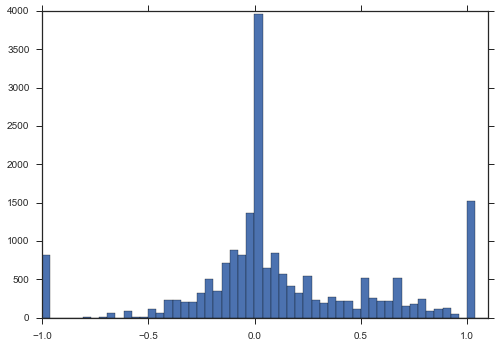

In [468]:
x = snp_fst_wc[~np.isnan(snp_fst_wc)]
plt.xlim(-1,1.1)
plt.hist(x, 100)

(array([  1.00000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.40000000e+01,
          0.00000000e+00,   1.30000000e+01,   0.00000000e+00,
          7.20000000e+01,   1.60000000e+01,   4.00000000e+00,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.20000000e+02,   0.00000000e+00,
          2.20000000e+01,   4.50000000e+01,   2.12000000e+02,
          2.82000000e+02,   3.40000000e+01,   9.70000000e+01,
          1.22000000e+02,   1.33000000e+02,   4.16000000e+02,
          6.11100000e+03,   1.41800000e+03,   1.30200000e+03,
          2.44000000e+02,   2.03400000e+03,   4.30000000e+01,
          1.47000000e+02,   2.00000000e+02,   3.40000000e+01,
          1.89000000e+02,   5.00000000e+01,   1.61700000e+03,
          5.20000000e+01,   1.77000000e+02,   3.66000000e+02,
        

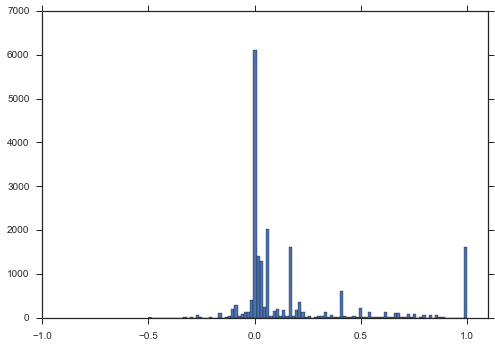

In [470]:
x = pf2[~np.isnan(pf2)]
plt.xlim(-1,1.1)
plt.hist(x, 100)

In [34]:
# Not stupid Pi
#ac_mar = g.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
#print(ac_mar)
#np.where( df_samples[1] == pop1 )
#sum = 0
#for i in range(len(g)):
#    sum += allel.stats.sequence_diversity( i, ac_mar )/225
#print( "pi fix = ", sum/len(g))
print(allel.stats.sequence_diversity( range(1, len(g)), ac_mar ))
c

0.15058086094


rec.array([[(True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0')],
 [(False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([1, 0], dtype=int8), 0, 0, '1|0'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0')],
 [(False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (False, False, array([-1, -1], dtype=in